In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

# Faber-Jackson relation:

[Faber-Jackson relation](https://iopscience.iop.org/article/10.3847/1538-4357/aa6540/pdf): On the Origin of the Fundamental Plane and Faber–Jackson Relations: Implications forthe Star Formation Problem. D'Onofrio, Cariddi, et al. The values of the slope and intercept are measured using the right plot of the Figure 7, where the early-type galaxies are represented by black dots.

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# Faber - Jackson relation
def luminosity_function(sigma):
    a, b = 2.01, 5.77 #slope and intercept for V-band
    L = 10**(a*np.log10(sigma) + b)
    return L #in solar luminosities

M_solar = 4.74 #Absolute magnitude of the Sun

def absolute_magnitude(L):
    M = M_solar - 2.5*np.log10(L)
    return M

def apparent_magnitude(M, z, k):
    m = M + cosmo.distmod(z).value + k
    return(m)

def angular_diameter(sigma, z, m, k):
    #[effective_radius] = kpc, [vel_dispersion]=km/s
    a, b, c = 1.4043, 0.3045, -8.8579 #orthogonal fit for g band
    D = cosmo.angular_diameter_distance(z).to(u.kpc).value
    first = (60*60*180*sigma**a)/(D*np.pi)
    second = (2*np.pi)**(2.5*b)/(1+z)**(10*b)
    third = 10**(b*m - b*k + c)
    re =  (first*second*third)**(1/(1-5*b))
    return(re)

In [3]:
def k_correction(b):
    filter_file = 'k_values/{}_passband.csv'.format(b)
    data = pd.read_csv(filter_file, names=['r', 'z', 'k'],
                           delim_whitespace=True, comment='#')
    function_kcorrection = interp1d(data['z'].values[1:], data['k'].values[1:], 
        fill_value=0.0)
    return(function_kcorrection)

In [4]:
# https://iopscience.iop.org/article/10.1086/589327/pdf (Table 4)
# Galaxy with Plate-MJD-Fiber ID: 1387-53118-532
band, z, sigma = 'g', 0.3583, 264
k = k_correction('g')(z)
L_table, re_table = 204*10**9, 2.90
L = luminosity_function(sigma)
M = absolute_magnitude(L)
m = apparent_magnitude(M, z, k)
re = angular_diameter(sigma, z, m, k)
print("Luminosity in solar units: %.2e"%(L))
print("Table luminosity in solar units: %.2e"%(L_table))
print("Absolute Magnitude: %.2e"%(M))
print("Apparent magnitude:" +str(m))
print("Angular diameter (angular size) in arc seconds: " + str(re))
print("Table angular diameter (angular size) in arc seconds: " + str(re_table))

Luminosity in solar units: 4.34e+10
Table luminosity in solar units: 2.04e+11
Absolute Magnitude: -2.19e+01
Apparent magnitude:19.217377086585756
Angular diameter (angular size) in arc seconds: 1.0085574798109804
Table angular diameter (angular size) in arc seconds: 2.9


In [5]:
data = pd.read_csv('data.csv',delimiter='\t',encoding='utf-8')
data.head()

,SDSS,Plate,MJD,Fiber,zFG,zBG,Imag,n_Imag,AI,Name,...,PA,sigma,e_sigma,Mph,Mul,Lens,n_Lens,Sloan,_RA,_DE
0,000802.96-000408.2,669,52559,156,0.4400,1.1924,18.65,d,0.12,J0008-0004,...,27.3,,,E,S,A,,Sloan,2.01233,-0.06894
1,002817.87-092934.3,653,52145,590,0.0565,0.7146,13.75,s,0.07,J0028-0929,...,78.9,147,7,L,S,X,,Sloan,7.07446,-9.49286
2,002907.77-005550.5,391,51782,88,0.2270,0.9313,17.09,d,0.04,J0029-0055,...,26.6,229,18,E,S,A,,Sloan,7.28237,-0.93069
3,003753.21-094220.1,655,52162,392,0.1955,0.6322,16.26,s,0.06,J0037-0942,...,11.4,279,14,E,S,A,,Sloan,9.47171,-9.70558
4,004402.90+011312.6,393,51794,456,0.1196,0.1965,15.73,s,0.04,J0044+0113,...,151.3,266,13,E,S,A,,Sloan,11.01208,1.22017


In [6]:
new_data, L_histogram, re_histogram = [], [], []
for index, row in data.iterrows():
    z, sigma = float(row['zFG']), row['sigma']
    k = k_correction('g')(z)
    L_table, re_table = row['L(V555)'], row['Re'] # Luminosity in V555 band
    if(sigma!='   ' and L_table!='   ' and re_table!='   '):
        sigma, L_table, re_table = float(sigma), float(L_table)*10**9, float(re_table)
        L = luminosity_function(sigma)
        M = absolute_magnitude(L)
        m = apparent_magnitude(M, z, k)
        re = angular_diameter(sigma, z, m, k)
        new_data.append([z, sigma, L_table, L, m, re_table, re])
        L_histogram.append(L/L_table)
        re_histogram.append(re/re_table)
new_data = pd.DataFrame(new_data, columns = ['z', 'Sigma (km/s)',
                        'L table (Lo)', 'L (Lo)', 'm (mag.s)', 
                        're table (arcs)', 're (arcs)'])

In [7]:
new_data.head()

,z,Sigma (km/s),L table (Lo),L (Lo),m (mag.s),re table (arcs),re (arcs)
0,0.0565,147.0,9.280000e+10,1.337543e+10,16.374648,15.21,4.007610
1,0.2270,229.0,7.630000e+10,3.260388e+10,18.499556,2.16,1.343514
2,0.1955,279.0,1.205000e+11,4.849137e+10,17.733069,2.19,1.581437
3,0.1196,266.0,6.880000e+10,4.405671e+10,16.739301,2.61,2.349155
4,0.2939,251.0,7.720000e+10,3.920525e+10,18.880879,1.38,1.137934


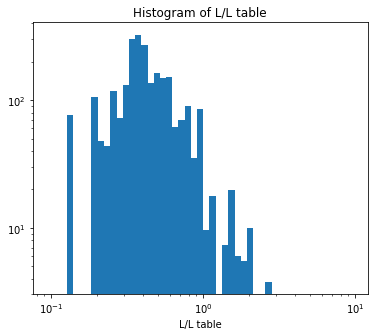

In [8]:
# Histogram of Luminosity calculated/Luminosity from table
bins = np.logspace(-1, 1, 50)
widths = (bins[1:] - bins[:-1])
hist = np.histogram(L_histogram, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

plt.figure(figsize=(6,5))
plt.title('Histogram of L/L table')
plt.bar(bins[:-1], hist_norm, widths)
plt.xlabel('L/L table')
plt.xscale('log')
plt.yscale('log')
plt.show()

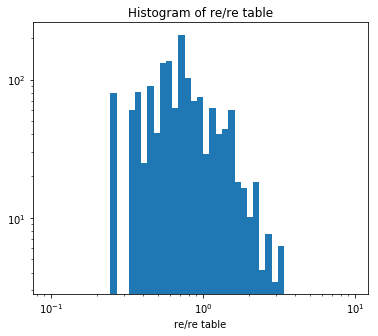

In [9]:
# Histogram of angular diameter calculated/angular diameter from table
bins = np.logspace(-1, 1, 50)
widths = (bins[1:] - bins[:-1])
hist = np.histogram(re_histogram, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

plt.figure(figsize=(6,5))
plt.title('Histogram of re/re table')
plt.bar(bins[:-1], hist_norm, widths)
plt.xlabel('re/re table')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [10]:
z_plot, sigma_plot, L_plot = [], [], []
for index, row in data.iterrows():
    z, sigma = float(row['zFG']), row['sigma']
    k = k_correction('g')(z) 
    L_table, re_table = row['L(V555)'], row['Re'] #Luminosity in V555 band
    if(sigma!='   ' and L_table!='   ' and re_table!='   '):
        sigma, L_table, re_table = float(sigma), float(L_table)*10**9, float(re_table)
        L = luminosity_function(sigma)
        M = absolute_magnitude(L)
        m = apparent_magnitude(M, z, k)
        re = angular_diameter(sigma, z, m, k)
        z_plot.append(z)
        sigma_plot.append(sigma)
        L_plot.append(L/L_table)

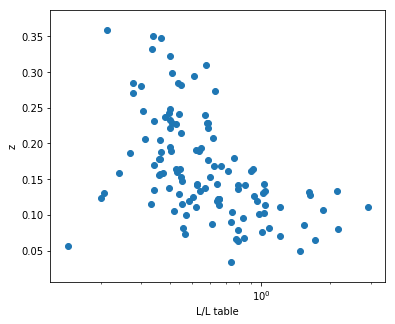

In [11]:
plt.figure(figsize=(6,5))
plt.xlabel("L/L table")
plt.ylabel("z")
plt.xscale('log')
plt.scatter(L_plot,z_plot)
plt.show()

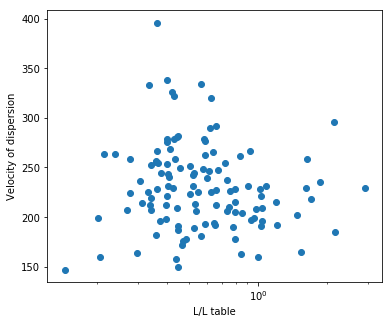

In [12]:
plt.figure(figsize=(6,5))
plt.xlabel("L/L table")
plt.ylabel("Velocity of dispersion")
plt.xscale('log')
plt.scatter(L_plot, sigma_plot)
plt.show()

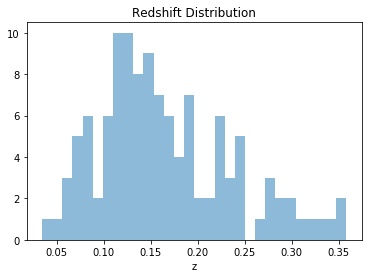

In [13]:
# redshift histogram
num_bins = 30
plt.figure()
n, bins, patches = plt.hist(z_plot, num_bins, alpha=0.5)
plt.title('Redshift Distribution')
plt.xlabel('z')
plt.show()